In [1]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import copy
import mne
import pickle
from LFCNN_decoder import SpatialParameters, TemporalParameters, ComponentsOrder, Predictions, WaveForms
import matplotlib.gridspec as gspec
from utils.storage_management import read_pkl
from utils.viz import plot_patterns

2023-09-10 15:14:00.011627: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 15:14:00.316736: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 15:14:00.318173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 15:14:02.084292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def draw_sp(
    iy: int,
    waveforms: WaveForms,
    temporal_parameters: TemporalParameters,
    spatial_parameters: SpatialParameters,
    info: mne.Info,
    *,
    logscale: bool = False,
    suptitle: str = None,
    vmin: int | float = None,
    vmax: int | float = None,
    flim: int = 70,
    crop: int | float = .05,
    shift: bool = True,
    show: bool = True,
    figsize: tuple[int, int] = (10, 15)
) -> mpl.figure.Figure:
    data = spatial_parameters.patterns.copy()
    induced = waveforms.induced.copy()[
        iy,
        :flim,
        :
    ]
    crop *= induced.shape[1] / 2

    for i, ind_course in enumerate(induced):
        induced[i] /= ind_course.mean()

    fig = plt.figure(constrained_layout=False)
    fig.set_size_inches(*figsize)
    gs2 = fig.add_gridspec(
        nrows=9,
        ncols=2,
        bottom=.1,
        wspace=.05,
        hspace=.1
    )
    ax21 = fig.add_subplot(gs2[:3, :])
    ax22 = fig.add_subplot(gs2[3:6, :])
    ax23 = fig.add_subplot(gs2[6:, :])
    _ = plot_patterns(data, info, iy, ax21, name_format='', show=False)
    ax22_t = ax22.twinx()
    ax22_t.plot(sp.stats.zscore(waveforms.evoked[iy]), '#454545')
    pos = ax22.imshow(np.flip(induced, axis=0), cmap='RdBu_r', vmin=vmin, vmax=vmax)
    cb = fig.colorbar(pos, ax=ax22, pad=0.2, orientation='horizontal', aspect=75, fraction=.12)
    ax22.set_aspect('auto')
    ax22_t.set_aspect('auto')
    _ = ax23.plot(
        temporal_parameters.franges,
        sp.stats.zscore(temporal_parameters.finputs[iy]),
        temporal_parameters.franges,
        sp.stats.zscore(temporal_parameters.foutputs[iy]),
        temporal_parameters.franges,
        sp.stats.zscore(temporal_parameters.fresponces[iy]),
    )
    ax22_t.set_ylabel('Amplitude', labelpad=30, rotation=270)
    ax22_t.spines['top'].set_alpha(.2)
    ax22_t.spines['right'].set_alpha(.2)
    ax22_t.spines['left'].set_alpha(.2)
    ax22_t.spines['bottom'].set_alpha(.2)
    ax22_t.tick_params(axis='both', which='both',length=5, color='#00000050')
    ax22.spines['top'].set_alpha(.2)
    ax22.spines['right'].set_alpha(.2)
    ax22.spines['left'].set_alpha(.2)
    ax22.spines['bottom'].set_alpha(.2)
    ax22.tick_params(axis='both', which='both',length=5, color='#00000050')
    cb.outline.set_color('#00000020')
    cb.ax.tick_params(axis='both', which='both',length=5, color='#00000050')
    times = np.unique(np.round(waveforms.times, 1))

    if shift:
        times = np.round(times - times.mean(), 2)

    ranges = np.linspace(0, len(waveforms.times), len(times)).astype(int)
    ax22.set_xticks(ranges)
    ax22.set_xticklabels(times)
    freqs = [0] + [(i+1) for i in range(waveforms.induced.shape[-2]) if (i+1)%10==0]
    ax22.set_yticks(freqs)
    ax22.set_yticklabels(sorted(freqs, reverse=True))
    ax22.set_xlabel('Time (s)')
    ax22.set_ylabel('Frequency (Hz)', labelpad=15)
    ax23.set_ylim(-2, 11)
    ax23.set_yticks([i for i in range(11) if (i+1)%2])
    ax23.legend(['Filter input', 'Filtering pattern', 'Filter response'], loc='upper right')
    ax23.spines['top'].set_alpha(.2)
    ax23.spines['right'].set_alpha(.2)
    ax23.spines['left'].set_alpha(.2)
    ax23.spines['bottom'].set_alpha(.2)
    ax23.tick_params(axis='both', which='both',length=5, color='#00000050')
    ax23.set_xlabel('Frequency (Hz)')
    ax23.set_ylabel('Amplitude')
    ax22_t.set_xlim([2 * crop, len(waveforms.times) - 2 * crop])
    ax23.set_xlim([0, 70])

    if logscale:
        ax23.set_yscale('log')
    if suptitle is None:
        fig.suptitle(f'Latent source {iy + 1}')
    else:
        fig.suptitle(suptitle)

    if show:
        plt.show()

    return fig


def info_pick_channels(info: mne.Info, ch_names: list[str]) -> mne.Info:
    sel = mne.pick_channels(info.ch_names, ch_names)
    return mne.pick_info(info, sel, copy=False, verbose=False)


def put_letter(letter: str, axis: plt.Axes, size: int = 20, coords: tuple[float, float] = (0.5, 0.5)):
    axis.text(*coords, letter, fontsize=size, horizontalalignment='center', verticalalignment='center')
    axis.axis('off')

'LM LI', 'RM RI'
fig4_1 ~ Fe_To 1
fig4_2 ~ Se_Tu 1
fig4_3 ~ Se_Tu 0

'LM', 'LI', 'RM', 'RI'
fig5_1 ~ Az_Mar 3
fig5_2 ~ Ga_Fed 3
fig5_3 ~ Se_Tu 1

'LM', 'LI'
fig5_1 ~ Az_Mar 2
fig5_2 ~ Ga_Fed 4
fig6_3 ~ Fe_To 2


/tmp/ipykernel_360094/217545378.py:6: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  content = pickle.load(


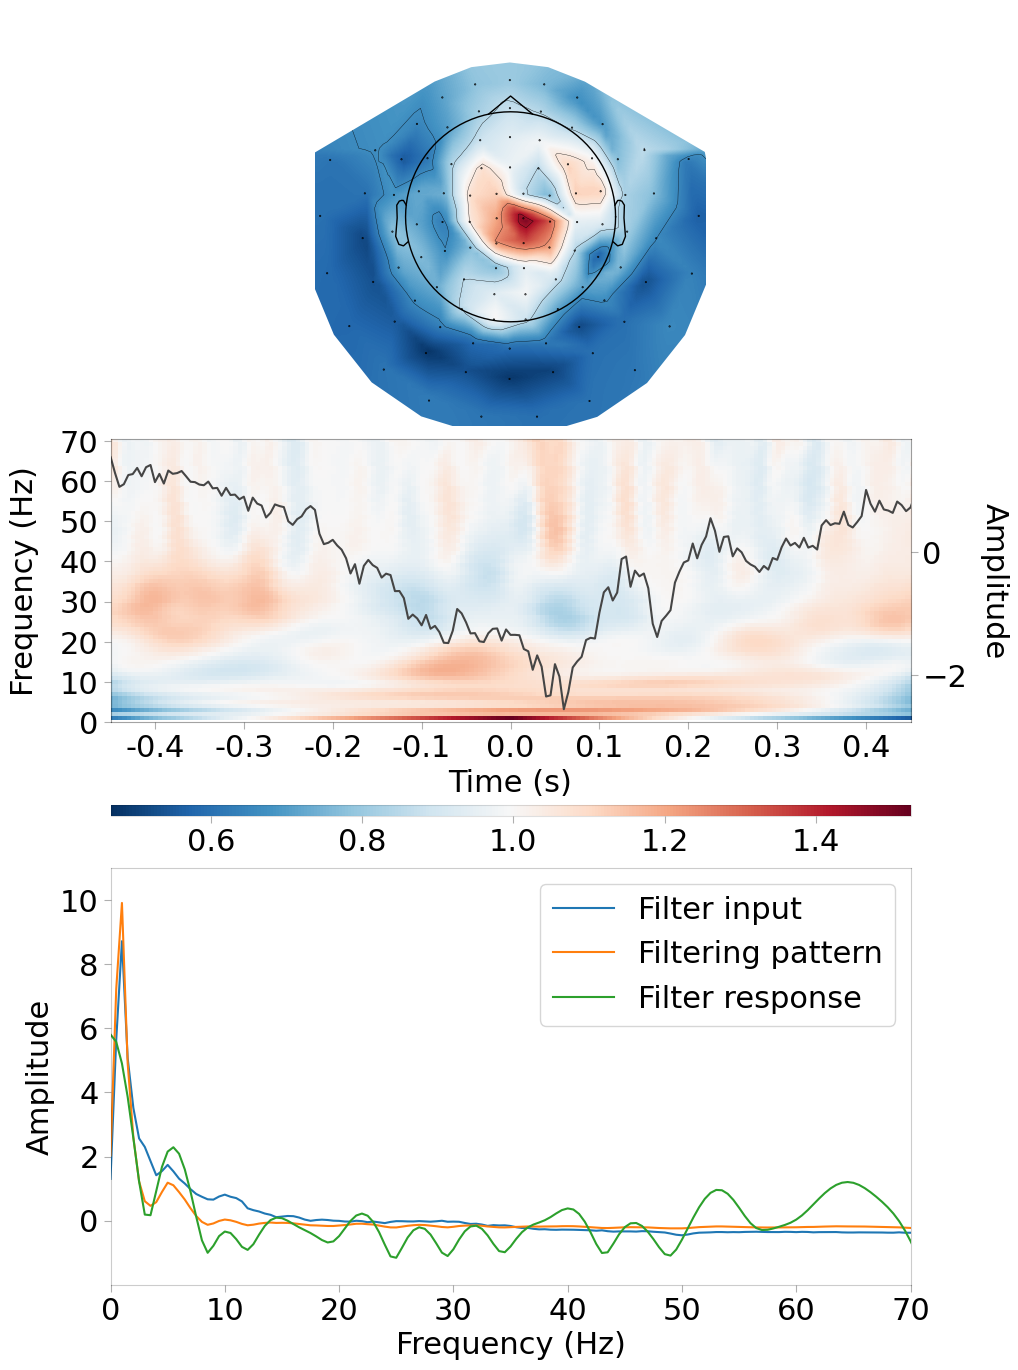

In [44]:
plt.rcParams.update({'font.size': 22})
subject_name = 'Ga_Fed'
i=4
path = '/home/user/Pictures/spatiotemporal.jpg'
cases_to_combine = ['LM', 'LI']

classification_name,\
    classification_postfix,\
    classification_prefix = None, '', ''
cases_to_combine = [case.split(' ') for case in cases_to_combine]

cases_to_combine = sorted(cases_to_combine, reverse=True)
class_names = ['&'.join(sorted(cases_combination, reverse=True)) for cases_combination in cases_to_combine]

if classification_name is None:
    classification_name = '_vs_'.join(class_names)

model='LFCNN'
subjects_dir = os.path.join('../', 'Source', 'Subjects')
classification_name_formatted = "_".join(list(filter(lambda s: s not in (None, ""), [classification_prefix, classification_name, classification_postfix])))
subject_info_path = os.path.join(subjects_dir, subject_name, 'Info')
subject_parameters_path = os.path.join(subjects_dir, subject_name, model, 'Parameters')
spatial_parameters = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_spatial.pkl'))
temporal_parameters = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_temporal.pkl'))
waveforms = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_waveforms.pkl'))
orders = read_pkl(os.path.join(subject_parameters_path, f'{classification_name_formatted}_sorting.pkl'))

info = read_pkl(os.path.join(subject_info_path, os.listdir(subject_info_path)[0]))
info_pick_channels(
    info,
    list(
        filter(
            lambda ch_name: (ch_name[-1] == '2' or ch_name[-1] == '3') and 'meg' in ch_name.lower(),
            info['ch_names']
        )
    )
)

fig = draw_sp(i, waveforms, temporal_parameters, spatial_parameters, info, suptitle='')
# plt.show()
fig.savefig(path, dpi=300)
plt.close()

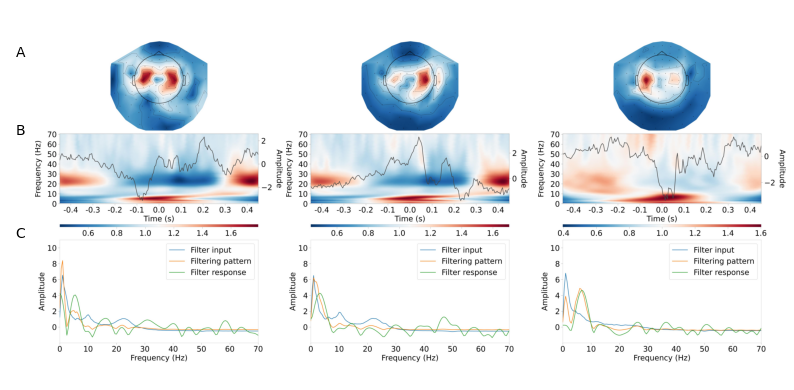

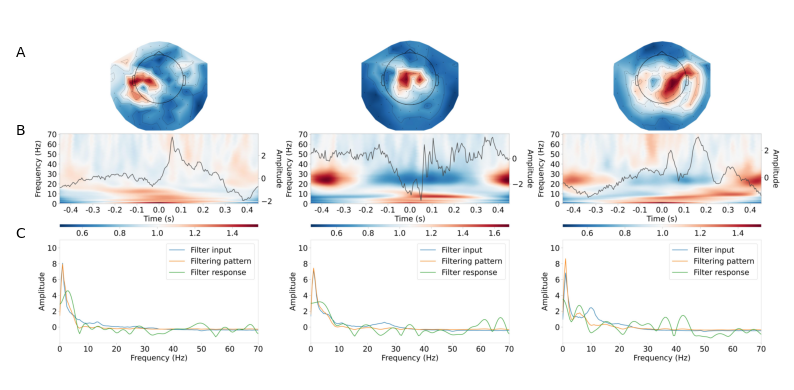

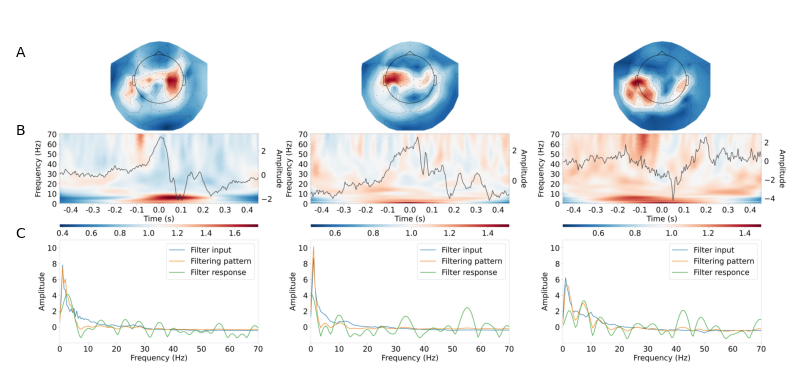

In [33]:
figsize = 10, 10
fontsize = 10

for figpat in ['fig4', 'fig5', 'fig6']:
    pics_dir = '/home/user/Pictures'

    fig_paths = [os.path.join(pics_dir, path) for path in os.listdir(pics_dir) if figpat in path.lower() and '_' in path.lower()]
    fig_images = [plt.imread(path) for path in fig_paths]

    fig = plt.figure(figsize = figsize)
    gs = gspec.GridSpec(30, 31)
    ax0_1 = fig.add_subplot(gs[9, 0])
    put_letter('A', ax0_1, fontsize)
    ax0_2 = fig.add_subplot(gs[12, 0])
    put_letter('B', ax0_2, fontsize)
    ax0_3 = fig.add_subplot(gs[16, 0])
    put_letter('C', ax0_3, fontsize)

    topo_axes = [
        fig.add_subplot(gs[:, 1:11]),
        fig.add_subplot(gs[:, 11:21]),
        fig.add_subplot(gs[:, 21:]),
    ]

    for ax, image in zip(topo_axes, fig_images):
        ax.imshow(image)
        ax.axis('off')

    # fig.subplots_adjust(left=0, bottom=0, right=0.1, top=0.1, wspace=0.5, hspace=0)
    fig.savefig(os.path.join(pics_dir, f'{figpat}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()